In [51]:
# Load Necessary Libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from numpy import argmax, argmin, arange

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, KFold, GridSearchCV
from sklearn.metrics import average_precision_score, recall_score, fbeta_score, make_scorer, auc, confusion_matrix, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

np.random.seed(123)

In [52]:
sns.set_theme(context='notebook', style='white', palette = None, font_scale=1)            

In [53]:
## Load preprocessed file

imputed_df = pd.read_csv('./parkinsons_train.csv', sep=',')
Xy_test= pd.read_csv('./parkinsons_test.csv', sep=',')

In [54]:
features = list(imputed_df.drop(columns = 'status').columns)
status = ["Healthy", 'PD']

In [55]:
# Separating outcome and explanatory variables into their resp. datasets

X_train = pd.DataFrame(imputed_df[features])
y_train = pd.DataFrame(imputed_df['status'])
X_test = pd.DataFrame(Xy_test[features])
y_test = pd.DataFrame(Xy_test['status'])

# Feature Scaling (MinMax Transformation)

We know our dataset has some features with bimodal distribution and also number of outliers left in some features is very low(within limits), hence we will apply minmax scaling to normalize the data features.

This is useful for algorithms (KNN, SVM, etc) which are based on measures like distance. Also it can speed up our algorithm and suppress the affect of remaining outliers.

In [56]:
transformer = MinMaxScaler()
ss = MinMaxScaler()
ss.fit(X_train)    
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [57]:
# Converting the outcome variable since our model algorithms expects it as 1-d array

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
y_train.shape

(136,)

# Metrics for Evaluation

Our Requirement is to have a FNR of max 0.1% i.e. our True Positive Rate(Recall) should be at least 0.9%., thus we will use recall score (binary) to keep a check on this.

Further we note that for our test False Negatives are more serious and thus we will use F2 score as our main metric for evaluation/comparison. Also since our dataset is moderartely imbalanced, hence we will use F2 micro score.

Also we will observe the average precision score(similar to PR auc) as a secondary metric as it focuses on the positive class (TP's) and is an appropriate measure for imbalanced datasets.

--------------------------

# Training Models 

We will use 4 simple  models : Logistic Regression, KNN, SVC(Gaussian), Decision Tree.

Also, we might try Ensemble models such as  bagging,boosting,stacking if needed.

### Default Threshold 0.5

We will use cross validate method on our training dataset for our 4 models with the default threshold (0.5) and observe the metrics.

Note: Recall score and F2 score metric are sensitive to threshold, hence we might have to set it before, so as to meet our 0.1% FNR requirement.

In [58]:
# cross_validate used to calulate multiple metrics
# make_scorer used to create f2_Score function

models=[]
models.append(('Logistic Regression',LogisticRegression(solver = 'liblinear', max_iter = 100)))
models.append(('KNN',KNeighborsClassifier(n_neighbors = 3, weights = 'distance')))
models.append(('SVC Gaussian',SVC(probability = True, random_state = 7)))
models.append(("Decision Tree",DecisionTreeClassifier(random_state = 7)))

all_results = dict()
predictions=[]

f2_score = make_scorer(fbeta_score, average = 'micro', beta=2)
metrics_def = {'average_precision_score':'average_precision', 'recall_score(binary)': 'recall', 'f2_score(micro)' : f2_score}

for name, model in models:
    fold = KFold(n_splits = 10, random_state = 2, shuffle = True)
    result = cross_validate(model,X_train,y_train,cv=fold,scoring= metrics_def, n_jobs = -1)
    result_dict = {i : result["test_" + i].mean() for i in metrics_def}    
    all_results[name] = pd.Series(result_dict)

results_df = pd.DataFrame(all_results)
results_df

,Logistic Regression,KNN,SVC Gaussian,Decision Tree
average_precision_score,0.973566,0.986104,0.994646,0.908248
recall_score(binary),0.972106,0.936702,0.972106,0.888337
f2_score(micro),0.860989,0.904945,0.883516,0.852747


We observe all our models achieve the mininmum requirement of 0.9% recall score except for Decision Tree with the default threshold. 

KNN has the best f2(micro) score of all.

### Set Threshold 0.1% FNR (0.9% TPR)

We will use cross validate method on our training dataset for our 4 models with the set threshold calculated from 0.1% FPR and then observe the metrics. 

We will calculate our threshold from precision recall curve. We will plot them to give us graphical view and we will plot the confusion matrix of total sum of k-folds as well to help us get a better understanding of our errors.

In [59]:
# Function to create labels to calculate metrics (score) at different thresholds

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

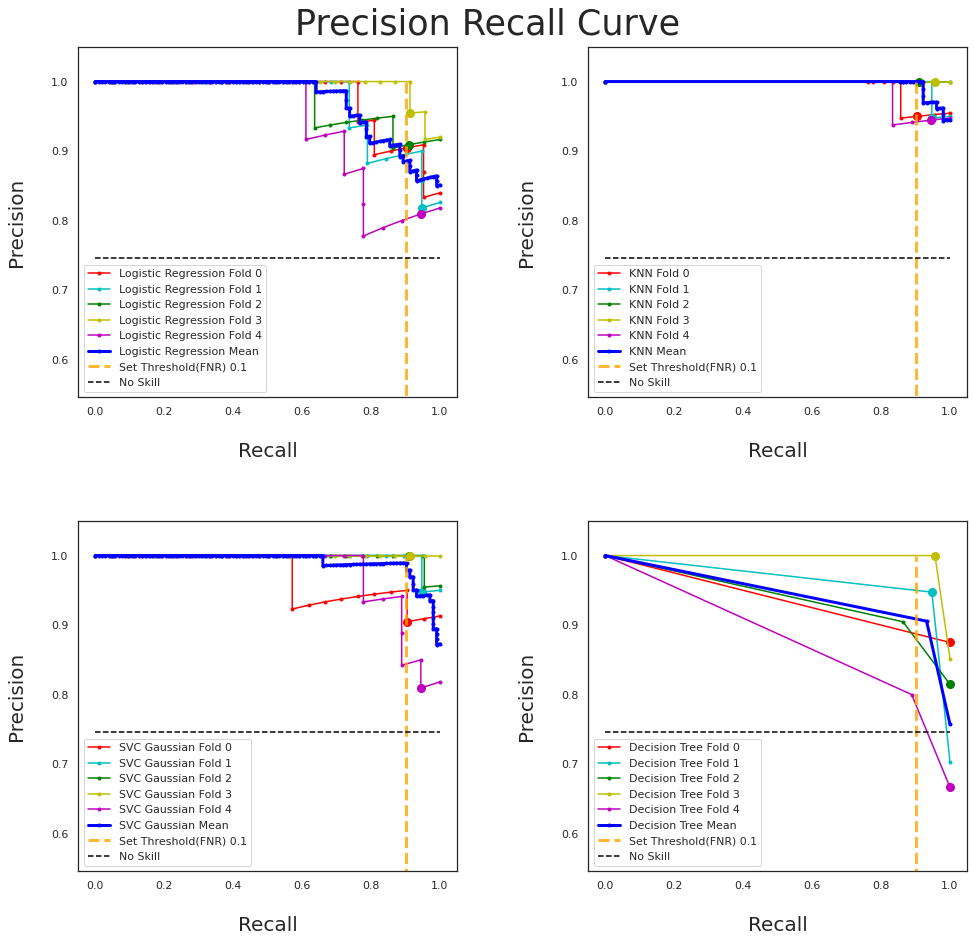

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(15, 14))
colours = ['r','c','g','y','m']
ax = ax.flatten()

all_results = dict()
all_cm= dict()

fold = KFold(n_splits = 5, random_state = 3, shuffle = True)

for (name, model),ax in zip(models,ax):
    y_real_cv = []
    y_proba_cv = []
    metrics_set= {'average_precision_score':[],'recall_score(binary)':[],'f2_score(micro)':[]}
    cmxs = {'cm' : []} 
    
    for i, (train, test) in enumerate(fold.split(X_train, y_train)):   
        model.fit(X_train[train], y_train[train])
        yhat = model.predict_proba(X_train[test])
        y_proba = yhat[:, 1]
        y_pred = model.predict(X_train[test])
            
            
    # Threshold calculated using precision-recall curve and argmin function
    
        recall_thresh = 0.9
        precision, recall, thresholds = precision_recall_curve(y_train[test], y_proba)
                       
        if recall_thresh > min(recall):
            idx,recall_thresh = map(lambda x: x([i for i in recall if i > recall_thresh]), [argmin,min])

        else:
            idx,recall_thresh = map(lambda x: x(recall), [argmin,min])
               
        thresh = thresholds[idx]
        precision_thresh = precision[idx]
        
    # Precision-recall curve for k-folds
        
        ax.plot(recall, precision, marker='.', color = colours[i], label= "{0} Fold {1}".format(name,i))
        ax.plot(recall_thresh, precision_thresh, marker='o', ms=8, color=colours[i])

        y_real_cv.append(y_train[test])
        y_proba_cv.append(y_proba)
        
        
 #  METRICS/ERROR (SCORING)

        metrics_set['average_precision_score'].append(average_precision_score(y_train[test], y_proba))
        metrics_set['recall_score(binary)'].append(recall_score(y_train[test], to_labels(y_proba, thresh), average = "binary"))
        metrics_set['f2_score(micro)'].append(fbeta_score(y_train[test], to_labels(y_proba, thresh), average = "micro", beta = 2))

        
#    CONFUSION MATRIX        

        cmx = confusion_matrix(y_train[test], y_pred,labels = [0,1])
        cmxs['cm'].append(cmx)

        
# Precision-recall curve mean for k-folds
    
    y_real_cv = np.concatenate(y_real_cv)
    y_proba_cv = np.concatenate(y_proba_cv)
    precision, recall, _ = precision_recall_curve(y_real_cv, y_proba_cv)
    no_skill = len(y_test[y_test==1]) / len(y_test)
        
    ax.plot(recall, precision, marker='.', color= 'b',lw =3, label= "{0} {1}".format(name,'Mean'))
    ax.plot([0.9,0.9],[0,1], linestyle='--', lw=3, color='orange', label="Set Threshold(FNR) 0.1" , alpha=.8)
    ax.plot([0,1], [no_skill,no_skill], linestyle='--', color = 'k', label='No Skill')
    ax.set_xlabel('Recall', fontsize = "20", labelpad = 25)
    ax.set_ylabel('Precision', fontsize = "20", labelpad = 25)
    ax.set(xlim=[-0.05, 1.05], ylim=[(no_skill-0.2), 1.05])
    ax.legend()    
    
    
# Saving to df,dict FOR DISPLAYING LATER

    for i in metrics_set:
                   result_dict[i] = np.asarray(metrics_set[i]).mean()
    
    all_results[name] = pd.Series(result_dict)
    
    result_cm = np.asarray(cmxs["cm"]).sum(axis = 0)
    all_cm[name] = result_cm   
    
#  Saving Params of decision tree (for later use)

    if name == "Decision Tree":
        dt_max_depth = model.tree_.max_depth
        dt_features = model.feature_importances_

results_df1 = pd.DataFrame(all_results)
        
plt.tight_layout(pad=5.0)
plt.suptitle("Precision Recall Curve", fontsize = "35")
plt.show()    

From the precision-recall curve we can observe KNN will have a higher f2 score followed by SVC(Gaussian) as both of them are closer to the upper right corner in comparison to the other two models.

Also note we have set our threshold value to correspond with 0.9% Recall(0.1% FNR), being equal to that rate or as close as possible on the higher side. Thats why all the models have slightly higher recall than the set limit.  

In [61]:
results_df1

,Logistic Regression,KNN,SVC Gaussian,Decision Tree
average_precision_score,0.971679,0.996255,0.988372,0.896157
recall_score(binary),0.923742,0.932437,0.923742,0.980778
f2_score(micro),0.845503,0.926720,0.889947,0.852646


We again note for the set FNR (set threshold), KNN has the best f2(micro) score.

In [62]:
## Fuction to plot Confusion Matrix for list of confusion matrices of different models

def plot_pred_cms(cms,n_rows,n_cols,axis_off = None):
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    ax = ax.flatten()
    
    if axis_off != None:
        try:
            for x in axis_off:
                [ax[x].set_axis_off() for x in axis_off]
        except:
            print("Axis_off is not a list")
            print("Trying to convert to list and continue\n")
            try:
                axis_off = [axis_off]
                for x in axis_off:
                    [ax[x].set_axis_off() for x in axis_off]
            except:
                print("Failed to convert to list")
                print("Enter a list to remove empty axes\n")    
    
    label = np.array([['TN','FP'],['FN','TP']])

    for (key,value),ax in zip(cms.items(),ax):
        text = (np.asarray(["{0}\n\n{1}".format(label, value) for label, value in zip(label.flatten(), value.flatten())])).reshape(2,2)
    
        ax = sns.heatmap(value, ax=ax,annot= text, linewidth = .5, cmap = 'icefire', fmt = "", annot_kws = {'size':20,'weight':'bold'}, cbar = False);
        ax.set_xlabel('Predicted',fontsize = 25)
        ax.set_ylabel('Truth',fontsize = 25)
        ax.set_title(key, y = 1.05, fontsize = 35)
    
    plt.tight_layout(pad=5.0)
    plt.show()

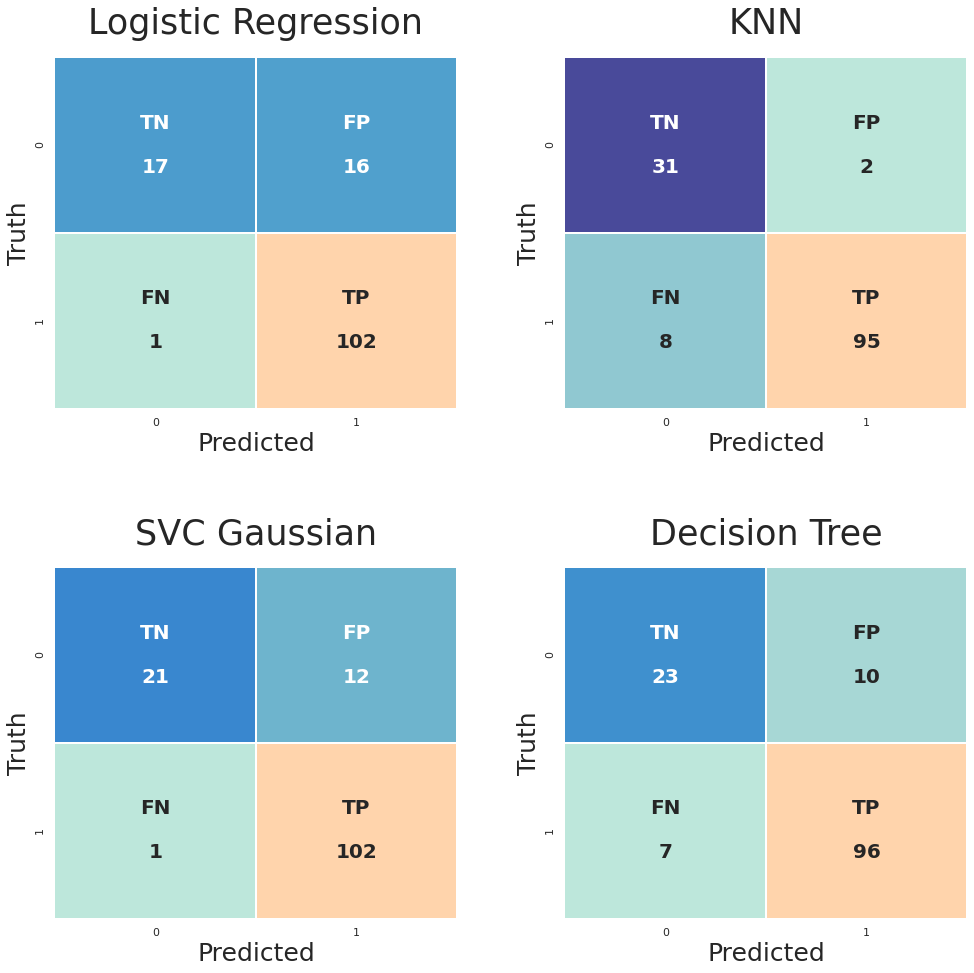

In [63]:
plot_pred_cms(all_cm,2,2)

These confusion matrices of different models are the sum of k-folds.

We again see KNN has performed very well with a high TP, low FN and low FP, thus leading to higher F2 (micro) score

# Grid Search for 3 Best Models

We will perform grid search on our models to further improve our score by finding the best hyperparamters.

We will use the default threshold first and then check if it meets our requirement of 0.1% FNR. The main metric for selecting our hyperparamter would be f2(micro) score.

### Logistic Regression Grid Search

In [64]:
fold = KFold(n_splits = 3, random_state = 7, shuffle = True)
all_GR = dict()

model = LogisticRegression(solver = "liblinear", max_iter = 100)
c = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
param_grid = dict(C=c)

GR = GridSearchCV(estimator = model, param_grid = param_grid, 
                  scoring = metrics_def, cv = fold, refit = "f2_score(micro)", n_jobs = -1)
GR_LR = GR.fit(X_train,y_train)

idx = argmax(GR_LR.cv_results_['mean_test_f2_score(micro)'])

result = {key : round((GR_LR.cv_results_["mean_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()}
result.update({"std_{0}".format(key) : round((GR_LR.cv_results_["std_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()})
result['params'] = GR_LR.cv_results_['params'][idx]
all_GR['Logistic Regression'] = pd.Series(result)

print("Best f2(micro) score: %f using %s "%(GR_LR.best_score_,GR_LR.best_params_))

Best f2(micro) score: 0.867311 using {'C': 0.8} 


### K-Nearest Neighbours Grid Search

In [65]:
model = KNeighborsClassifier(weights = 'distance', n_jobs = -1)
no_neighbours = arange(1, 15, 1)
param_grid = dict(n_neighbors = no_neighbours)

GR = GridSearchCV(estimator = model, param_grid = param_grid, 
                  scoring = metrics_def, cv = fold, refit = "f2_score(micro)", n_jobs = -1)    
GR_KNN = GR.fit(X_train,y_train)

idx = argmax(GR_KNN.cv_results_['mean_test_f2_score(micro)'])

result = {key : round((GR_KNN.cv_results_["mean_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()}
result.update({"std_{0}".format(key) : round((GR_KNN.cv_results_["std_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()})
result['params'] = GR_KNN.cv_results_['params'][idx]
all_GR['KNN'] = pd.Series(result)

print("Best f2(micro) score: %f using %s "%(GR_KNN.best_score_,GR_KNN.best_params_))

Best f2(micro) score: 0.940902 using {'n_neighbors': 1} 


### KNN Error Rate Estimation

                     Error
No_of_neighbours          
1                 0.059098
2                 0.059098
3                 0.088567
4                 0.081159
5                 0.081159
6                 0.088567
7                 0.095813
8                 0.125282
9                 0.110628
10                0.110628
11                0.118035
12                0.118035
13                0.118035
14                0.110628


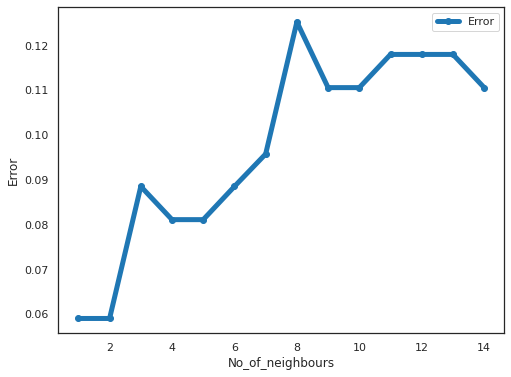

In [66]:
KNN_error = 1 - (GR_KNN.cv_results_["mean_test_f2_score(micro)"])
KNN_error_df = pd.DataFrame({'No_of_neighbours':param_grid['n_neighbors'] ,'Error': KNN_error}).set_index('No_of_neighbours')

print(KNN_error_df)

KNN_error_df.plot(marker = 'o', figsize= (8,6),linewidth=5, ylabel = 'Error')
plt.show()

Graphical view of KNN error rate estimation clearly showing error rate increasing after n is greater than 2.
The fit method chose k = 1 as the hyperparameter but we will choose k = 2 to fit the model as we can see from the graph where the elbow is formed. 

Also, k=1 would be highly sensitive to noise, outliers etc and has a greater chance of overfitting in comparison to k=2 which will be slightly more robust.

### Support Vector Machine (Gaussian) Grid Search

In [67]:
model = SVC(kernel = 'rbf', probability=True, random_state = 7)
gamma = [.5,1,3,5,10]
c = [0.1,1,3,5,10]
param_grid = dict(gamma = gamma, C=c)

GR = GridSearchCV(estimator = model, param_grid = param_grid, 
                  scoring = metrics_def, cv = fold, refit = "f2_score(micro)", n_jobs = -1)    
GR_SVM = GR.fit(X_train,y_train)

idx = argmax(GR_SVM.cv_results_['mean_test_f2_score(micro)'])

result = {key : round((GR_SVM.cv_results_["mean_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()}
result.update({"std_{0}".format(key) : round((GR_SVM.cv_results_["std_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()})
result['params'] = GR_SVM.cv_results_['params'][idx]
all_GR['SVM Gaussian'] = pd.Series(result)

print("Best f2(micro) score: %f using %s "%(GR_SVM.best_score_,GR_SVM.best_params_))

Best f2(micro) score: 0.948470 using {'C': 3, 'gamma': 3} 


### Decision Tree Grid Search

In [68]:
model = DecisionTreeClassifier(random_state = 7)
param_grid = {'max_depth': range(1, dt_max_depth + 1, 2), 'max_features': range(1, len(dt_features + 1))}

GR = GridSearchCV(estimator = model, param_grid = param_grid, 
                  scoring = metrics_def, cv = fold, refit = "f2_score(micro)", n_jobs = -1)    
GR_DT = GR.fit(X_train,y_train)

idx = argmax(GR_DT.cv_results_['mean_test_f2_score(micro)'])

result = {key : round((GR_DT.cv_results_["mean_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()}
result.update({"std_{0}".format(key) : round((GR_DT.cv_results_["std_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()})
result['params'] = GR_DT.cv_results_['params'][idx]
all_GR['Decision Tree'] = pd.Series(result)

print("Best f2(micro) score: %f using %s "%(GR_DT.best_score_,GR_DT.best_params_))

Best f2(micro) score: 0.933816 using {'max_depth': 5, 'max_features': 7} 


# Ensemble Method for Decision Tree

### Gradient Boosting Grid Search

In [69]:
model = GradientBoostingClassifier(max_features = 3, random_state = 7)
param_grid = {'n_estimators': [15,25,50,100,200,400,600,1000,1500,2000,2500]}

GR = GridSearchCV(estimator = model, param_grid = param_grid, 
                  scoring = metrics_def, cv = fold, refit = "f2_score(micro)", n_jobs = -1)    
GR_DT = GR.fit(X_train,y_train)

print("Best f2(micro) score:: %f using %s "%(GR_DT.best_score_,GR_DT.best_params_))

Best f2(micro) score:: 0.941546 using {'n_estimators': 1500} 


### GBC Error Rate Estimation

                Error
No_of_trees          
15           0.095974
25           0.095813
50           0.081159
100          0.073591
200          0.073591
400          0.080998
600          0.066184
1000         0.065862
1500         0.058454
2000         0.058454
2500         0.065862


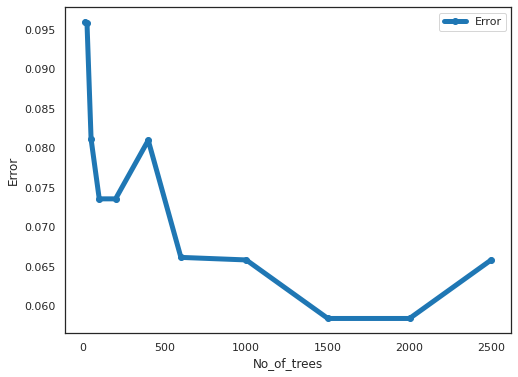

In [70]:
GBC_error = 1 - (GR_DT.cv_results_["mean_test_f2_score(micro)"])
GBC_error_df = pd.DataFrame({'No_of_trees':param_grid['n_estimators'] ,'Error': GBC_error}).set_index('No_of_trees')

print(GBC_error_df)

GBC_error_df.plot(marker = 'o', figsize= (8,6),linewidth=5, ylabel = 'Error')
plt.show()

Graphical view of Gradient Boosting error rate estimation clearly showing error rate becomes constant at 1500 number of trees till 2000 and then starts increasing again after that.

Hence we will choose 1500 as it will be the most optimum choice with regard to prediction and speed.

After choosing it we can do the grid search again to find other hyperparameters keeping no of trees constant at 1500.

In [71]:
model = GradientBoostingClassifier(n_estimators = 1500, random_state = 7)
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              "subsample" : [1.0, 0.5],
              "max_features": [2,3,4,5]}

GR = GridSearchCV(estimator = model, param_grid = param_grid, 
                  scoring = metrics_def, cv = fold, refit = "f2_score(micro)", n_jobs = -1)    
GR_GB = GR.fit(X_train,y_train)

idx = argmax(GR_GB.cv_results_['mean_test_f2_score(micro)'])

result = {key : round((GR_GB.cv_results_["mean_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()}
result.update({"std_{0}".format(key) : round((GR_GB.cv_results_["std_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()})
result['params'] = GR_GB.cv_results_['params'][idx]
all_GR['Gradient Boosting'] = pd.Series(result)

print("Best f2(micro) score: %f using %s "%(GR_GB.best_score_,GR_GB.best_params_))

Best f2(micro) score: 0.941546 using {'learning_rate': 0.1, 'max_features': 2, 'subsample': 1.0} 


## Comparing All Models after Grid Search

In [72]:
pd.DataFrame(all_GR)

,Logistic Regression,KNN,SVM Gaussian,Decision Tree,Gradient Boosting
average_precision_score,0.973,0.951,0.997,0.951,0.996
recall_score(binary),0.99,0.961,0.971,0.952,0.947
f2_score(micro),0.867,0.941,0.948,0.934,0.942
std_average_precision_score,0.005,0.032,0.002,0.016,0.004
std_recall_score(binary),0.014,0.014,0.003,0.011,0.055
std_f2_score(micro),0.037,0.028,0.011,0.018,0.037
params,{'C': 0.8},{'n_neighbors': 1},"{'C': 3, 'gamma': 3}","{'max_depth': 5, 'max_features': 7}","{'learning_rate': 0.1, 'max_features': 2, 'sub..."


After choosing the appropriate hyperparameters using grid search, all models meet the requirement of 0.1% FNR, and have a much a lower FNR.
SVM(Gaussian), Graident Boosting and KNN are the best 3 models with high f2(micro) score.

# Best 3 Models Predictions

We will now compare the scores of the 3 best models by fitting them to test dataset and also checking the confusion matrix to get a better idea of the errors.

In [73]:
# Function for calculating the metrics and confusion matrices of best models

def model_test1(x,y):
    best_models = [("KNN", GR_KNN), ("SVM", GR_SVM),("Gradient Boosting", GR_GB)]
    pred_metrics = dict()
    pred_cms = dict()
    for name, model in best_models:
        model_predict = model.predict(x)
        pred = dict()        
        pred['average_precision_score'] = average_precision_score(y,model_predict)
        pred['recall_score(binary)'] = recall_score(y, model_predict, average = "binary")
        pred['f2_score(micro)'] = fbeta_score(y,model_predict, average = "micro", beta = 2)
        cm = confusion_matrix(y, model_predict,labels = [0,1])
        #cmxs['cm'].append(cmx) 
        pred_cms[name] = cm 
        pred_metrics[name] = pd.Series(pred)
    return pred_metrics,pred_cms

#### Checking the best models on training data first for any errors

In [74]:
best_pred_df,best_pred_cms = (model_test1(X_train,y_train))
pd.DataFrame(best_pred_df)

,KNN,SVM,Gradient Boosting
average_precision_score,1.0,1.0,1.0
recall_score(binary),1.0,1.0,1.0
f2_score(micro),1.0,1.0,1.0


Metrics(Scores) on training data look correct with perfect score

Axis_off is not a list
Trying to convert to list and continue



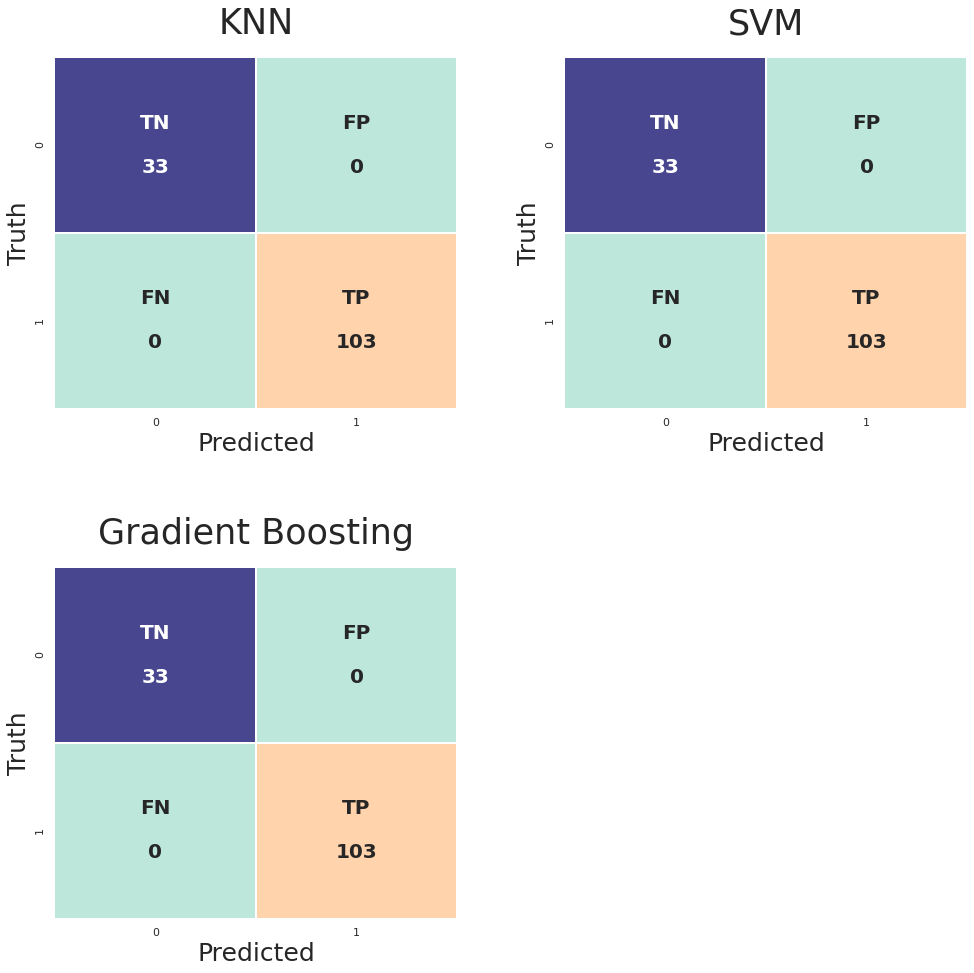

In [75]:
plot_pred_cms(best_pred_cms,2,2,-1)

Confusion Matrices on training set look correct with perfect score

#### Testing best models on test dataset

In [76]:
best_pred_df,best_pred_cms = (model_test1(X_test,y_test))
pd.DataFrame(best_pred_df)

,KNN,SVM,Gradient Boosting
average_precision_score,0.924807,0.869126,0.880000
recall_score(binary),0.954545,0.954545,1.000000
f2_score(micro),0.915254,0.864407,0.898305


We observe KNN has the best f2(micro) score followed by Gradient Boosting and then SVM.

Gradient Boosting has the highest recall(binary) score, a perfect 1 and also has a very high f2(micro) score

All 3 models have a high average precision score as well which means they detect TP's very well.

Axis_off is not a list
Trying to convert to list and continue



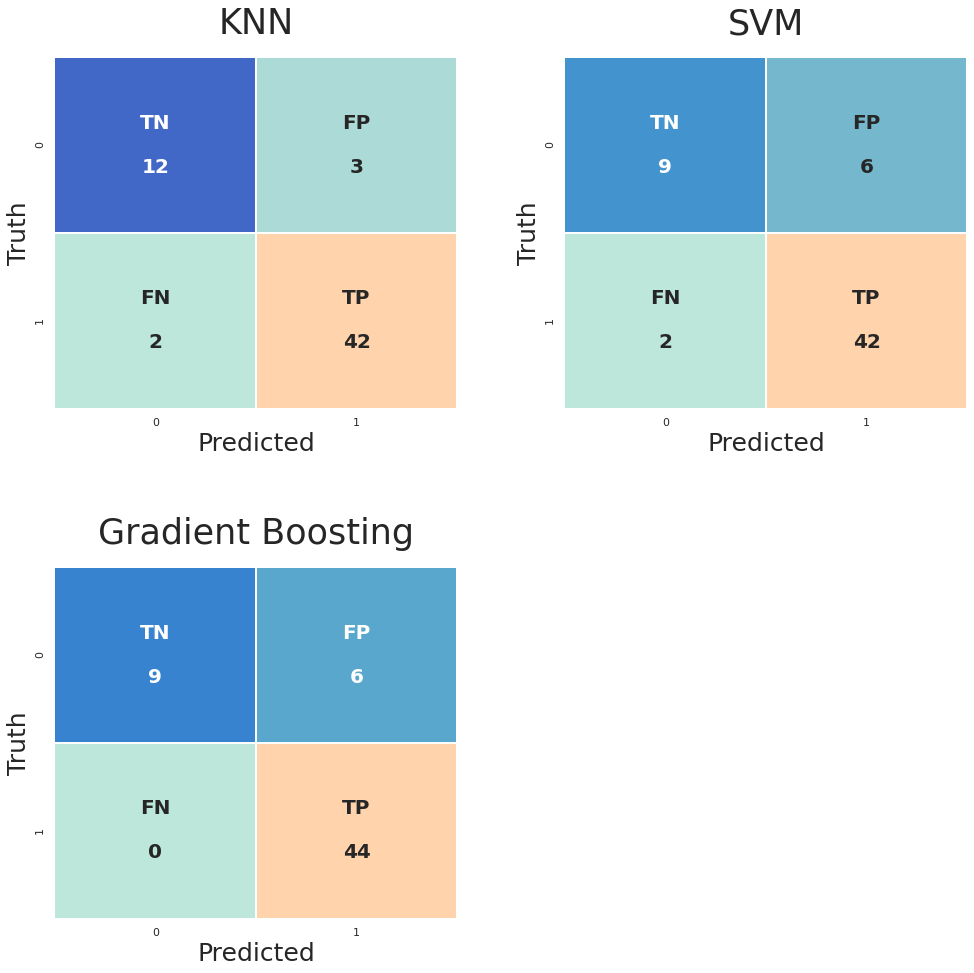

In [77]:
plot_pred_cms(best_pred_cms,2,2,-1)

We again see KNN has performed very well with a high TP, low FN and low FP, thus leading to higher F2 (micro) score.
We also note Gradient Boosting has 0 FN although at the cost of higher FP's.

# Stacking

We can try to further optimimze our model by stacking and compare the score. 
We will stack together Gradient Boosting and KNN models.

Note: Here we will directly try only 1 combination to predict the score without using Grid Search.

In [78]:
estimators = [("GB", GR_GB), ("KNN", GR_KNN)]
VC = VotingClassifier(estimators, voting = "soft", n_jobs = -1)
VC = VC.fit(X_train, y_train)

In [79]:
vc_pred = VC.predict(X_test)
print("Voting Classifier Testing Set Prediction:\n")
print(f"average_precision_score: {average_precision_score(y_test,vc_pred)}")
print("recall_score(binary): {0}".format(recall_score(y_test,vc_pred, average = "binary")))
print("f2_score(micro): {0}".format(fbeta_score(y_test,vc_pred, average = "micro", beta = 2))) 

Voting Classifier Testing Set Prediction:

average_precision_score: 0.9248073959938368
recall_score(binary): 0.9545454545454546
f2_score(micro): 0.9152542372881356


We observe our stack model has the same score as  KNN.

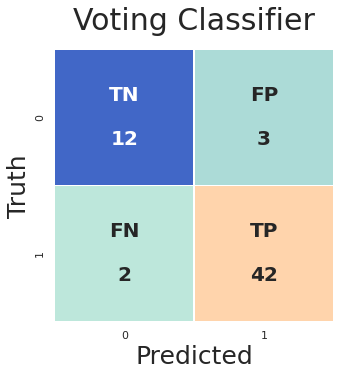

In [80]:
plt.figure(figsize = (5, 5))
label = np.array([['TN','FP'],['FN','TP']])
cm = confusion_matrix(y_test, vc_pred,labels = [0,1])
text = (np.asarray(["{0}\n\n{1}".format(label, cm) for label, cm in zip(label.flatten(), cm.flatten())])).reshape(2,2)

ax = sns.heatmap(cm, annot= text, linewidth = .5, cmap = 'icefire', fmt = "", annot_kws = {'size':20,'weight':'bold'}, cbar = False);
ax.set_xlabel('Predicted',fontsize = 25)
ax.set_ylabel('Truth',fontsize = 25)
ax.set_title('Voting Classifier', y = 1.05, fontsize = 30)
plt.show()

We observe our stack model has the same TP, FN and FP as  KNN.

# Results

We observed KNN had the best f2(micro) score with a very high recall(score) followed by Gradient Boosting having a perfect recall score of 1 and a very high f2(micro).
Also all the models had a high average precision score.
Voting classifier didnt help us in improving our prediction anymore and remained the same as KNN.

All 3 models met the minimum requirement of 0.1% FNR using the default threshold.

Finally, we can choose either KNN or Gradient Boostinig depending on whether we want higher specificity or higher sensitivity

# Suggestion for Next Steps

* To further improve, we can try to gather more information about the data like sex,age etc if available.
 The tests and theiravailable results can also be segregrated then thus improving our prediction results and addressing issues of variance and bias.
* Also gathering more data can greatly help in improving our prediction and checking of varaince and bias.
* As our dataset is small and imbalaced, we can upsample to further reduce the imbalance.
* Get an experts advice on the subject for which outliers to treat or try fitting a robust model without      removing outliers such as Robust Scaler, Decision Trees etc.
* We can use unsupervised learning techniques such as DBscan, isolation forest to detect our outliers and   remove extreme ones or replace/impute them or group them and test the data by adding a new a column       feature to represent different groups.
* Try dimensional reducing techniques such as PCA, MDS etc to reduce number of features
* Try other models like Linear SVM, Naive Bayes, Bagging and compare their results
* Try Grid search for stacking model, to find the best weights and order for the estimators.
* Try LightGBM for faster training speed and higher efficiency.